In [81]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import overpy not using, wasn't giving nds, which we need for ordering
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import sys
sys.path.append(f'/home/beans/bespoke')

from map_utils import *
from big_map_utils import *

In [83]:
%%time

lats, lons, all_way_ids = get_big_map()

lats.shape, lons.shape, way_ids.shape #TODO stack these three arrays together for better perf later, slight

CPU times: user 612 ms, sys: 39.2 ms, total: 651 ms
Wall time: 1.01 s


((52470,), (52470,), (0,))

CPU times: user 20.7 ms, sys: 19 µs, total: 20.8 ms
Wall time: 18.9 ms


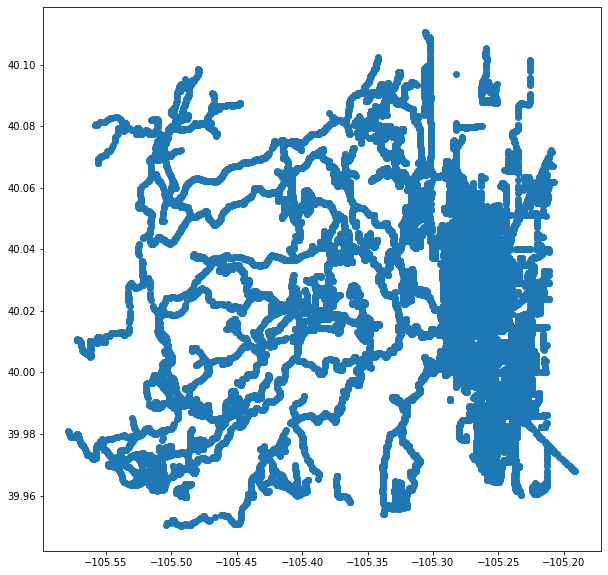

In [84]:
%%time
plt.figure(figsize=(10,10))
plt.scatter(lons, lats)

In [85]:
# Narrowing down to window around vehicle. 
# Everything below will be called every frame, so it should take only a few ms as to not impede on our 50ms modeld loop

#current_lat, current_lon = 44.973490, -122.645679 #nabq curves
# current_lat, current_lon = 45.023867, -122.741862 # start sabq
current_lat, current_lon = 39.990675519055074, -105.44785300059655 # 90 shady hollow
vehicle_heading = 0 #+ np.pi/2 # need this hardcoded rotater

In [86]:
LOCAL_LON_MULT = get_lon_mult(current_lat)
current_x, current_y = current_lon*LOCAL_LON_MULT, current_lat
all_xs, all_ys = lons*LOCAL_LON_MULT, lats

In [87]:
%%time
xs, ys, way_ids = prepare_small_map_nodes(all_xs, 
                                          all_ys, 
                                          all_way_ids, 
                                          current_x, 
                                          current_y, 
                                          vehicle_heading, 
                                          CLOSE_BUFFER,
                                         )
xs.shape, ys.shape, way_ids.shape

CPU times: user 1.49 ms, sys: 198 µs, total: 1.69 ms
Wall time: 1.19 ms


((189,), (189,), (189,))

CPU times: user 16.4 ms, sys: 4.11 ms, total: 20.5 ms
Wall time: 19.7 ms


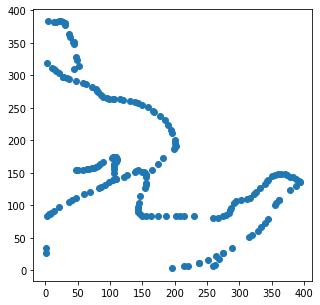

In [88]:
%%time
plt.figure(figsize=(5,5))
plt.scatter(xs, ys)

In [89]:
small_map = draw_small_map(xs, ys, way_ids)
small_map.shape

(400, 400, 3)

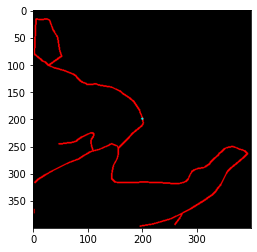

In [90]:
plt.imshow(small_map)

In [91]:
route = np.load(f"{ROUTES_DIR}/home_to_end_rr.npy")
route_xs = route[:, 0]*LOCAL_LON_MULT
route_ys = route[:, 1]
draw_route = True

vehicle_heading = 3

In [92]:
%%time
xs, ys, way_ids = prepare_small_map_nodes(route_xs, 
                                          route_xs, 
                                          np.ones_like(route_xs), 
                                          current_x, 
                                          current_y, 
                                          vehicle_heading, 
                                          CLOSE_BUFFER,
                                         )
xs.shape, ys.shape, way_ids.shape

CPU times: user 188 µs, sys: 0 ns, total: 188 µs
Wall time: 151 µs


((0,), (0,), (0,))

In [93]:
small_map = get_map(all_xs, 
                    all_ys, 
                    all_way_ids, 
                    route_xs, 
                    route_ys, 
                    current_x, 
                    current_y, 
                    vehicle_heading, 
                    CLOSE_BUFFER, 
                    draw_route=True)

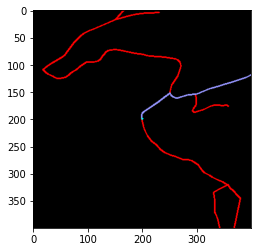

In [94]:
plt.imshow(small_map)

In [100]:
run_id = "run_518" # out and back from nabq

run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
car_state_paths = sorted(glob.glob(f"{run_path}/car_state/*"))
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))[:]])#.astype(np.float16)
lat, lon = car_state[:,12], car_state[:,13]
LOCAL_LON_MULT = get_lon_mult(lat.mean())

In [109]:
car_state.shape

(3267, 16)

In [110]:
len(lat)

3267

In [111]:
heading_tracker = HeadingTracker()

In [117]:
maps = []
for i in range(len(lat)):
    current_x, current_y = lon[i]*LOCAL_LON_MULT, lat[i]
    current_speed_mps = kph_to_mps(car_state[i,5])
    vehicle_heading = heading_tracker.step(current_x, current_y, current_speed_mps)

    small_map = get_map(all_xs, 
                        all_ys, 
                        all_way_ids, 
                        route_xs,
                        route_ys,
                        current_x, 
                        current_y, 
                        vehicle_heading, 
                        CLOSE_BUFFER,
                        draw_route)
    maps.append(small_map)

In [118]:
len(maps)

3267

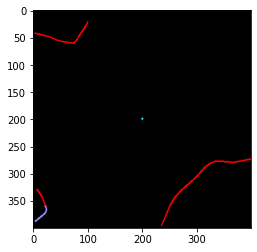

In [127]:
plt.imshow(maps[0])

In [129]:
lon[0]

-105.44837333333334

In [130]:
lat[0]

39.993566666666666

CPU times: user 11.6 ms, sys: 3.89 ms, total: 15.5 ms
Wall time: 13.8 ms


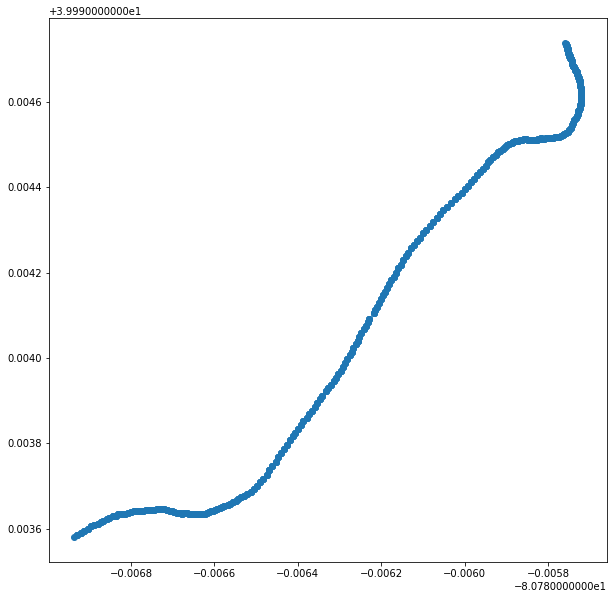

In [131]:
%%time
plt.figure(figsize=(10,10))
plt.scatter(lon[-1000:]*LOCAL_LON_MULT, lat[-1000:])

In [132]:
lat.max()

39.99473833333333

In [63]:
xs, ys = [10,20,30,40,50,60], [10,20,30,40,50,60]
pts = np.stack([xs, ys], axis=-1)
pts.shape

(6, 2)

In [64]:
pts = pts.reshape((-1, 1, 2))  # quirk of cv2
pts.shape

(6, 1, 2)

In [65]:
# Drawing
isClosed = False
color = (255, 0, 0)
thickness = 2

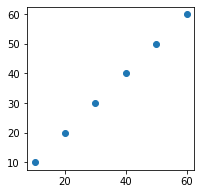

In [66]:
plt.figure(figsize=(3,3))
plt.scatter(xs, ys)

In [67]:
small_map = np.zeros((60, 60, 3), dtype='uint8') 

In [68]:
small_map = cv2.polylines(small_map, [pts], isClosed, color, thickness)

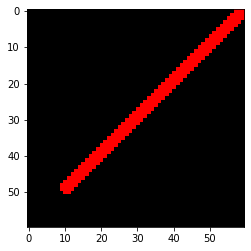

In [69]:
plt.imshow(np.flipud(small_map))